In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [7]:
#Test de vulnérabilité sur un modèle shallow softmax
#Entrainement sur le dataset de train MNIST
#Evaluation sur le dataset de test MNSIT
#Evaluation sur le dataset de train MNIST avec modif FGSM
#Evaluation sur le dataset de test MNIST avec modif FGSM
#Ces evaluations sont effectuées pour les optimizer SGD et Adam

In [7]:
#Optimizer SGD

# Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64
epsilon = 0.25  # Valeur du papier pour MNIST 

transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True)

# Modèle Softmax (Régression Logistique Multinomiale)
# Simple couche linéaire : 784 (28x28) -> 10 classes
model = nn.Linear(28*28, 10).to(device)

# training
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
criterion = nn.CrossEntropyLoss()
epoch=3

print("Entraînement du modèle Softmax...")
model.train()
for i in range(1,epoch+1):
    for images, labels in trainloader:
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Loss pour l'epoch {i}/{epoch} : {loss}")
print("Entraînement terminé.")

#Fonction FGSM
def fgsm_attack(model, data, target, epsilon):
    """Renvoie l'image perturbée par FGSM."""
    data = data.clone().detach().to(device)
    data.requires_grad = True
    target = target.to(device)
    
    output = model(data)
    loss = criterion(output, target)
    
    model.zero_grad()
    loss.backward()
    
    data_grad = data.grad.data
    perturbed_data = data + epsilon * data_grad.sign()
    perturbed_data = torch.clamp(perturbed_data, 0, 1)
    
    return perturbed_data

#Fonction d'évaluation
def evaluate(model, dataloader, adversarial=False):
    """Évalue le modèle sur un dataloader, adversarial ou non"""
    correct = 0
    total = 0
    model.eval()
    
    for images, labels in dataloader:
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)
        
        if adversarial:
            images = fgsm_attack(model, images, labels, epsilon)
            outputs = model(images)
        else:
            with torch.no_grad():
                outputs = model(images)
        
        preds = outputs.max(1, keepdim=True)[1]
        correct += preds.eq(labels.view_as(preds)).sum().item()
        total += labels.size(0)
    
    acc = 100 * correct / total
    return acc

def mean_confidence_on_errors(model, dataloader, adversarial=False):
    """Calcule la confiance moyenne (softmax) sur les erreurs de classification"""
    model.eval()
    confidences = []

    for images, labels in dataloader:
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        if adversarial:
            images = fgsm_attack(model, images, labels, epsilon)
            outputs = model(images)
        else:
            with torch.no_grad():
                outputs = model(images)

        probs = torch.softmax(outputs, dim=1)
        preds = probs.argmax(dim=1)

        # Sélection des erreurs
        mask = preds != labels
        if mask.any():
            conf = probs[mask, preds[mask]]
            confidences.extend(conf.detach().cpu().tolist())

    if len(confidences) == 0:
        return 0.0

    return sum(confidences) / len(confidences)


#Evaluation
acc_test_clean = evaluate(model, testloader, adversarial=False)
conf_test_clean = mean_confidence_on_errors(model, testloader, adversarial=False)
acc_test_adv = evaluate(model, testloader, adversarial=True)
conf_test_adv = mean_confidence_on_errors(model, testloader, adversarial=True)
acc_train_adv = evaluate(model, trainloader, adversarial=True)
conf_train_adv = mean_confidence_on_errors(model, trainloader, adversarial=True)

print(f"Accuracy Test Clean   : {acc_test_clean:.2f}%")
print(f"Confiance moyenne erreurs Test Clean : {conf_test_clean:.4f}")
print(f"Accuracy Test FGSM    : {acc_test_adv:.2f}%")
print(f"Confiance moyenne erreurs Test FGSM  : {conf_test_adv:.4f}")
print(f"Accuracy Train FGSM   : {acc_train_adv:.2f}%")
print(f"Confiance moyenne erreurs Train FGSM : {conf_train_adv:.4f}")


Entraînement du modèle Softmax...
Loss pour l'epoch 1/3 : 0.5738165974617004
Loss pour l'epoch 2/3 : 1.0365217924118042
Loss pour l'epoch 3/3 : 0.2862597703933716
Entraînement terminé.
Accuracy Test Clean   : 91.84%
Confiance moyenne erreurs Test Clean : 0.6721
Accuracy Test FGSM    : 0.05%
Confiance moyenne erreurs Test FGSM  : 0.9329
Accuracy Train FGSM   : 0.07%
Confiance moyenne erreurs Train FGSM : 0.9305


In [6]:
#Optimizer Adam

# Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64
epsilon = 0.25  # Valeur du papier pour MNIST 

transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True)

# Modèle Softmax (Régression Logistique Multinomiale)
# Simple couche linéaire : 784 (28x28) -> 10 classes
model = nn.Linear(28*28, 10).to(device)

# training
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
epoch=3

print("Entraînement du modèle Softmax... (optimizer Adam)")
model.train()
for i in range(1,epoch+1): 
    for images, labels in trainloader:
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Loss pour l'epoch {i}/{epoch} : {loss}")
print("Entraînement terminé.")

#Fonction FGSM
def fgsm_attack(model, data, target, epsilon):
    """Renvoie l'image perturbée par FGSM."""
    data = data.clone().detach().to(device)
    data.requires_grad = True
    target = target.to(device)
    
    output = model(data)
    loss = criterion(output, target)
    
    model.zero_grad()
    loss.backward()
    
    data_grad = data.grad.data
    perturbed_data = data + epsilon * data_grad.sign()
    perturbed_data = torch.clamp(perturbed_data, 0, 1)
    
    return perturbed_data

#Fonction d'évaluation
def evaluate(model, dataloader, adversarial=False):
    """Évalue le modèle sur un dataloader, adversarial ou non"""
    correct = 0
    total = 0
    model.eval()
    
    for images, labels in dataloader:
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)
        
        if adversarial:
            images = fgsm_attack(model, images, labels, epsilon)
            outputs = model(images)
        else:
            with torch.no_grad():
                outputs = model(images)
        
        preds = outputs.max(1, keepdim=True)[1]
        correct += preds.eq(labels.view_as(preds)).sum().item()
        total += labels.size(0)
    
    acc = 100 * correct / total
    return acc

def mean_confidence_on_errors(model, dataloader, adversarial=False):
    """Calcule la confiance moyenne (softmax) sur les erreurs de classification"""
    model.eval()
    confidences = []

    for images, labels in dataloader:
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        if adversarial:
            images = fgsm_attack(model, images, labels, epsilon)
            outputs = model(images)
        else:
            with torch.no_grad():
                outputs = model(images)

        probs = torch.softmax(outputs, dim=1)
        preds = probs.argmax(dim=1)

        mask = preds != labels
        if mask.any():
            conf = probs[mask, preds[mask]]
            confidences.extend(conf.detach().cpu().tolist())

    if len(confidences) == 0:
        return 0.0

    return sum(confidences) / len(confidences)

#Evaluation
acc_test_clean = evaluate(model, testloader, adversarial=False)
conf_test_clean = mean_confidence_on_errors(model, testloader, adversarial=False)
acc_test_adv = evaluate(model, testloader, adversarial=True)
conf_test_adv = mean_confidence_on_errors(model, testloader, adversarial=True)
acc_train_adv = evaluate(model, trainloader, adversarial=True)
conf_train_adv = mean_confidence_on_errors(model, trainloader, adversarial=True)

print(f"Accuracy Test Clean   : {acc_test_clean:.2f}%")
print(f"Confiance moyenne erreurs Test Clean : {conf_test_clean:.4f}")
print(f"Accuracy Test FGSM    : {acc_test_adv:.2f}%")
print(f"Confiance moyenne erreurs Test FGSM  : {conf_test_adv:.4f}")
print(f"Accuracy Train FGSM   : {acc_train_adv:.2f}%")
print(f"Confiance moyenne erreurs Train FGSM : {conf_train_adv:.4f}")


Entraînement du modèle Softmax... (optimizer Adam)
Loss pour l'epoch 1/3 : 0.2908087372779846
Loss pour l'epoch 2/3 : 0.30940333008766174
Loss pour l'epoch 3/3 : 0.0588844008743763
Entraînement terminé.
Accuracy Test Clean   : 92.15%
Confiance moyenne erreurs Test Clean : 0.6201
Accuracy Test FGSM    : 0.00%
Confiance moyenne erreurs Test FGSM  : 0.8750
Accuracy Train FGSM   : 0.00%
Confiance moyenne erreurs Train FGSM : 0.8728


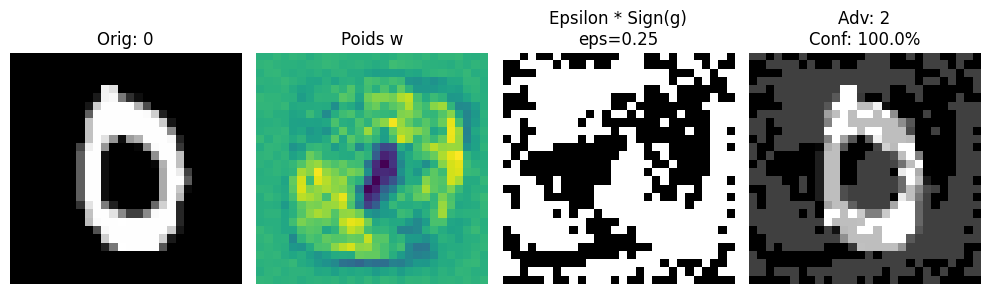

In [11]:
# Visualisation des poids du réseau (figure 2)

dataiter = iter(testloader)
images, labels = next(dataiter)

images = images.view(-1, 28*28).to(device)
label = labels.to(device)

# calcul gradient
images.requires_grad = True
outputs = model(images)
loss = criterion(outputs, label)
model.zero_grad()
loss.backward()
data_grad = images.grad.data


# x_adv = x + epsilon * sign(grad)
sign_data_grad = data_grad.sign()
adv_images = images + epsilon * sign_data_grad
adv_images = torch.clamp(adv_images, 0, 1) 

# prédiction
with torch.no_grad():
    outputs_adv = model(adv_images)
    probs_adv = torch.softmax(outputs_adv, dim=1)
    adv_conf, adv_pred = probs_adv.max(1)


plt.figure(figsize=(10, 5))

# image inchangée
plt.subplot(1, 4, 1)
plt.title(f"Orig: {label.item()}")
plt.imshow(images.detach().cpu().reshape(28, 28), cmap='gray')
plt.axis('off')

# Poids de la classe prédite
weights = model.weight.data[label.item()].reshape(28, 28).cpu()
plt.subplot(1, 4, 2)
plt.title("Poids w")
plt.imshow(weights, cmap='viridis') 
plt.axis('off')

# perturbation
plt.subplot(1, 4, 3)
plt.title(f"Epsilon * Sign(g)\neps={epsilon}")
plt.imshow(sign_data_grad.cpu().reshape(28, 28), cmap='gray')
plt.axis('off')

# image perturbée
plt.subplot(1, 4, 4)
plt.title(f"Adv: {adv_pred.item()}\nConf: {adv_conf.item()*100:.1f}%")
plt.imshow(adv_images.detach().cpu().reshape(28, 28), cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

Entraînement du modèle Softmax...
Entraînement terminé.


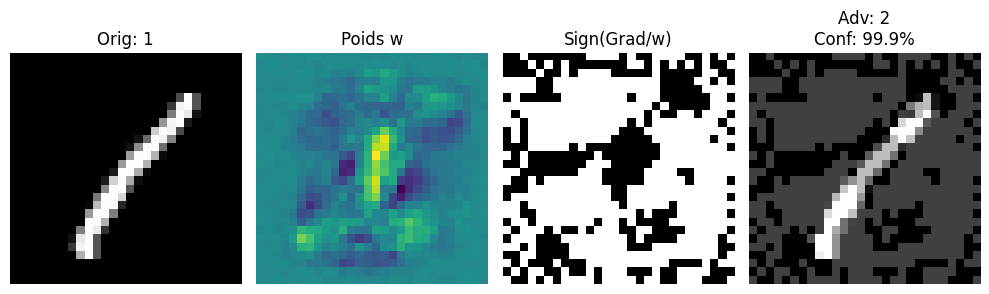


--- Test 'Rubbish Class' (Bruit Gaussien) ---
Entrée : Bruit Gaussien aléatoire
Prédiction du modèle : 7
Confiance : 82.37%
Note: Une confiance > 50% sur du bruit pur confirme la vulnérabilité linéaire .


In [ ]:
# Rubbish Class Examples
# bruit Gaussien
print("\n Test 'Rubbish Class'")
rubbish_noise = torch.randn(1, 28*28).to(device) # Bruit normal centrée 0

# Prédiction
output_rubbish = model(rubbish_noise)
rubbish_pred = output_rubbish.max(1, keepdim=True)[1]
rubbish_conf = torch.nn.functional.softmax(output_rubbish, dim=1)[0][rubbish_pred].item()

print(f"Entrée : Bruit Gaussien aléatoire")
print(f"Prédiction du modèle : {rubbish_pred.item()}")
print(f"Confiance : {rubbish_conf*100:.2f}%")
print("Une confiance > 50% sur du bruit pur confirme la vulnérabilité linéaire ")